# GROUP M - BEAT THE BOOKIE NOTEBOOK

# Section 1: Introduction


This notebook presents our approach to predict the outcome of the English Premier League (EPL) matches by training suitable machine learning algorithms on historic data. Our end goal is to create a model that can predict the home win, draw or away win of upcoming match fixtures. To understand the nature of the data, we first explore the data using data visualisation and then preprocess the data by adding new features. We then compare several different models of classification and choose the best performing model.


- Our final model accuracy of the XGBoost after hyperparameter optimisation is 53.66 % with time series splitting.



# Section 2: Library and Data Import


The below libaries are imported. Installation code has been commented for ease of use.

In [0]:
#!pip install xgboost
#!pip install -U statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
from IPython.display import display, clear_output
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import math
import operator
import heapq
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')  # this ignores all the warnings making our not-so-elegant code cleaner :)
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import scale


Importing the given data file (epl-training.csv) from github account. 


In [0]:
# read .csv file with pandas.read_csv
data_source = 'https://raw.githubusercontent.com/hmahendran/epl-data/master/DataFiles/epl-training.csv'
data = pd.read_csv(data_source)
data = data.iloc[:,:22]
data.columns = ["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR", "HHTG", "AHTG", "HTR", "Referee", "HSoG", "ASoG", "HSoT","ASoT","HFouls","AFouls", "HCorners", "ACorners", "HYellows", "AYellows", "HReds", "AReds"]
data.Date = pd.to_datetime(data.Date,dayfirst=True)
if data.shape == (4180,22):
  print('All Data Loaded')

#del data['Date']
data.drop(data.iloc[:, 18:22], inplace = True, axis = 1)
data.drop(data.iloc[:,6:10],inplace = True, axis = 1)
data #preview of the intial data

All Data Loaded


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HSoG,ASoG,HSoT,ASoT,HFouls,AFouls,HCorners,ACorners
0,2008-08-16,Arsenal,West Brom,1,0,H,24,5,14,4,11,8,7,5
1,2008-08-16,Bolton,Stoke,3,1,H,14,8,8,2,13,12,4,3
2,2008-08-16,Everton,Blackburn,2,3,A,10,15,5,11,11,9,3,5
3,2008-08-16,Hull,Fulham,2,1,H,11,12,6,6,10,9,5,6
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,14,8,10,5,11,12,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,3,11,4,1
4176,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,9,6,11,2
4177,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,8,6,4,3
4178,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,10,13,7,4


The data imported is correct and has a total of 22 features. These include the 10 individual features split up between home and away teams, as well as the date and the referee for a given game. Out of the ten features we selected the 6 more important feature categories:
- Date: Date of game
- Home Team and Away Team
- HFTG/AFTG: Full time goals for each team giving the final score
- FTR: Full time result taking the form of either a home win, draw or an away win
- HSoG/ASoG: Shots on goals by the home/away teams
- HSoT/ASoT: Shots on goals by the home/away teams
- HFouls/AFouls: Fouls by the home/away teams
- HCorners/ACorners: Number of corners by the home/away teams

# Section 3: Data Transformation and Exploration

After understanding the different features, we initially plot some basic data trends to see how the general data is distributed.

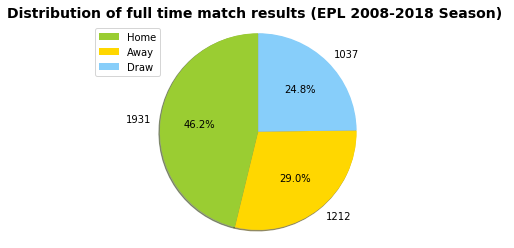

In [0]:
#Plotting a pie chart to see data distribution
HWins = np.sum(data.FTR == 'H')
AWins = np.sum(data.FTR == 'A')
DWins = np.sum(data.FTR == 'D')
labels = ['Home', 'Away', 'Draw']
sizes = [HWins, AWins, DWins]
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts, juck = plt.pie(sizes, labels = sizes , colors=colors, shadow=True, startangle=90, radius = 2, autopct='%1.1f%%')
plt.title("Distribution of full time match results (EPL 2008-2018 Season) ",size=14,fontweight='bold')
plt.legend(patches, labels, loc="upper left")
plt.axis('equal')
plt.show()

The FTR is displayed as H, A, D for a home win, away win and draw respectively, which needs to be classified numerically in the future. We see that the within the data set, a large proportion of it is classified as 'Home Wins'. To explore this further we looked at other features which may also display this trend.

Other than the FTR, the only other qualitative feature is 'referees' which should not have an impact on the match results.

We have identified 'shots on goal', 'shots on target' and 'corners' as features that we identified that could be strongly associated with the FTR as these statistics describe how many goal scoring opportunities a given team has.

In [0]:
data[['HSoG','ASoG','HSoT','ASoT','HCorners','ACorners']].describe() 

,HSoG,ASoG,HSoT,ASoT,HCorners,ACorners
count,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000,4180.000000
mean,14.133493,11.182057,6.147608,4.847129,6.048565,4.781818
std,5.487821,4.665311,3.486477,2.913169,3.137784,2.734701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,8.000000,4.000000,3.000000,4.000000,3.000000
50%,14.000000,11.000000,6.000000,4.000000,6.000000,4.000000
75%,17.000000,14.000000,8.000000,6.000000,8.000000,6.000000
max,43.000000,30.000000,24.000000,20.000000,20.000000,19.000000


From the pie chart, it shows that there are more home wins, indiciating that playing in the home court gives some advantage. The data we identified as the most related to the FTR of the game also indicate the presence of a home advantage. The mean of HSoG > ASoG, HSoT > ASot and HCorners > ACorners, further proving this hypothesis. The inherent reason of a home advantage could be due to factors such has less travel time, a stronger fan base, etc. We must somehow incorporate this into our model.

Next, we look at whether the number of goals scored by a team throughout a season, impacts it's final points for the same season.

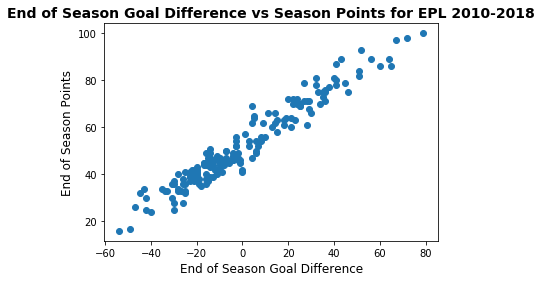

In [0]:
#Importing Goal Difference and Final Season points data - gddata
gddata = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/Goal%20Difference%20Data%20(1).csv')

gddata = gddata.iloc[1:,3:5] #Just keeping the 2 columns we need
gddata.columns = ['FSP','GD'] #Renaming the columns
gddata = gddata.dropna() #Dropping NaN Columns - Teams that don't play in a given season
gddata =gddata.astype(float) #Converting to Float
# Assign data
x = gddata['GD']
y = gddata['FSP']
plt.scatter(x,y)
plt.xlabel('End of Season Goal Difference',size=12)
plt.ylabel('End of Season Points',size=12)
plt.title("End of Season Goal Difference vs Season Points for EPL 2010-2018",size=14,fontweight='bold')
plt.show()

By plotting the total goal difference against the total points at the end of each season for each team, it is evident that there is a strong positive correlation. Suggesting that teams with a higher goal difference, achieve a greater amount of points. Thus, when predicting what team is likely to win, using each teams goal difference can be a good indicator based on the previous data. However, it can be noted that this is not always the case, as some teams with relatively high points have had relatively low goal differences. Nonetheless, incorporating the goal difference as a feature will be beneficial when predicting match results.

## Data Exploration

## Feature Engineering

To further explore the data further, after undertaking research, we found two methods of incorporating new features:
- Poisson Regression Model for Attack and Defensive Strength
- Elo Rating System

### **Poission Regression Model for Attack and Defensive Strength**


Justification for the Poisson Model

There are several existing statistical models that have tried to accurately predict match results with varying levels of success. One such model is the Poisson model. This assumes that the number of goals scored in a game by two separate teams can be modelled as two independent Poisson distributed variables.

In order to have a feel for why this can be done, the graph below shows how the proportion of matches with a certain number of home and away goals can be approximated by a two seperate Poisson distributions.

In [0]:
data #Viewing the data before using the Poisson model

,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HSoG,ASoG,HSoT,ASoT,HFouls,AFouls,HCorners,ACorners
0,2008-08-16,Arsenal,West Brom,1,0,H,24,5,14,4,11,8,7,5
1,2008-08-16,Bolton,Stoke,3,1,H,14,8,8,2,13,12,4,3
2,2008-08-16,Everton,Blackburn,2,3,A,10,15,5,11,11,9,3,5
3,2008-08-16,Hull,Fulham,2,1,H,11,12,6,6,10,9,5,6
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,14,8,10,5,11,12,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,2,0,H,13,7,5,2,3,11,4,1
4176,2019-05-12,Man United,Cardiff,0,2,A,26,13,10,4,9,6,11,2
4177,2019-05-12,Southampton,Huddersfield,1,1,D,10,10,3,3,8,6,4,3
4178,2019-05-12,Tottenham,Everton,2,2,D,11,17,3,9,10,13,7,4


In [0]:
# data must be ran from section 2 to have 14 rows or the system won't recognise
data = data.iloc[:,:14]
data.columns = ["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR", "HSoG", "ASoG", "HSoT","ASoT","HFouls","AFouls", "HCorners", "ACorners"]#, "HYellows", "AYellows", "HReds", "AReds"]
data.Date = pd.to_datetime(data.Date,dayfirst=True)

#Isolate Primary Attributes
data = data.loc[:,["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR"]]

#2019 data import
data_2019 = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/2019-2020.csv')

data_2019.Date = pd.to_datetime(data_2019.Date,dayfirst=True)
data_2019 = data_2019.loc[:,['Date', 'HomeTeam', 'AwayTeam','FTHG','FTAG','FTR', 'HTHG', 'HTAG','HS','AS','HST','AST']]
data_2019.columns = ['Date', 'HomeTeam', 'AwayTeam','HFTG','AFTG','FTR', 'HHTG', 'AHTG','HSoG','ASoG','HSoT','ASoT']
data_2019 = data_2019.loc[:,['Date', 'HomeTeam', 'AwayTeam','HFTG','AFTG','FTR']]

data_2019
data = data.append(data_2019,ignore_index=True)


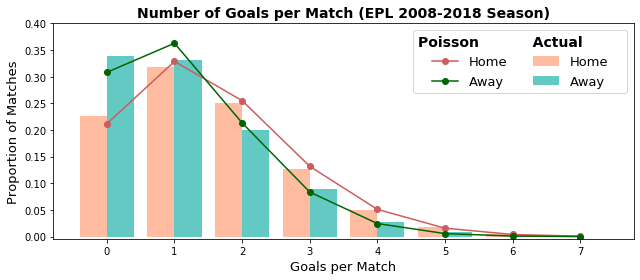

In [0]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, data.mean()[j]) for i in range(8)] for j in range(2)])

fig, ax = plt.subplots(figsize=(9,4))  
# plot histogram of actual goals
plt.hist(data[['HFTG', 'AFTG']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2008-2018 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

#### Creating a simple model for each team

To model specific matches we need to know the average number of goals scored by each team and feed this data into a Poisson model. This can be done by passing the data through a Generalised Linear Model Algorithm of the Poisson family and requesting a model summary. This outputs a set of model parameters. The one of interest is the coefficient column which is comparable to the slopes in linear regression. 

By taking the exponent of the parameter values, we get a multiplier, that describes how more likely a team is to score. A positive value implies more goals ($ e^x > 1 ∀ x>0 $), while values closer to zero represent more neutral effects ($e^0=1$).

The coefficient which describes the home advantage is found at the bottom of the table, which equals 0.2899. This explains the assumption that a home team is more likely to score (specifically, $e^{0.2899} = 1.336$ times more likely). 

Teams have varying coefficients depending on their abilities. This is given by the 'team' coefficient. 

For example, Chelsea has a coefficient of 0.0023, while the corresponding value for Sunderland is -0.5772 (which means that Chelsea (Sunderland) are better (much worse!) scorers than average). 

On the other hand, the 'opponent' coefficient penalises/rewards teams based on the quality of the opposition. Also, the 'home' coefficient explained earlier, contributes to the team that is playing at home.

When simulating a match, the average goals scored by the home team takes into accound the 'team' coefficient of the home team and the 'opponent' coefficient of the away team, as well as the 'home' coefficient.

On the other hand, the average goals scored by the away team takes into account the 'team' coefficient of the away team and the 'opponent' coefficient of the home team, whilst disregarding the 'home' coefficient. 



In [0]:
# importing the tools required for the Poisson regression model

# the home field advantage term - it's the same value for every team

import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([data[['HomeTeam','AwayTeam','HFTG']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HFTG':'goals'}),
           data[['AwayTeam','HomeTeam','AFTG']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AFTG':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                 8778
Model:                            GLM   Df Residuals:                     8704
Model Family:                 Poisson   Df Model:                           73
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12654.
Date:                Tue, 07 Jan 2020   Deviance:                       9855.1
Time:                        11:19:03   Pearson chi2:                 8.56e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [0]:
# As each team is treated independently, we can construct a match score probability matrix.

def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

# This matrix simply shows the probability of Arsenal (rows of the matrix)
# and Southampton (matrix columns) scoring a specific number of goals. 
# For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.0507).
# So, you can calculate the odds of draw by summing all the diagonal entries. 
# Everything below the diagonal represents a Arsenal victory (e.g P(3-0)=0.074).

ars_sou = simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=10)
matrix_columns = np.core.defchararray.add(["Southamption_" for x in range(0,5)],["0","1","2","3","4"])
matrix_rows = np.core.defchararray.add(["Arsenal_" for x in range(0,5)],["0","1","2","3","4"])
result_matrix = pd.DataFrame(ars_sou[0:5, 0:5],index=matrix_rows,columns=matrix_columns)

result_matrix


,Southamption_0,Southamption_1,Southamption_2,Southamption_3,Southamption_4
Arsenal_0,0.049333,0.046109,0.021548,0.006713,0.001569
Arsenal_1,0.102342,0.095653,0.044701,0.013927,0.003254
Arsenal_2,0.106155,0.099217,0.046367,0.014445,0.003375
Arsenal_3,0.073407,0.068610,0.032063,0.009989,0.002334
Arsenal_4,0.038071,0.035583,0.016629,0.005181,0.001211


Problems with a simple Poisson model

Dixon and Coles claim that low score results (0-0, 1-0, 0-1 and 1-1) are inherently under-reported by the simple Poisson model. The matrix below shows the average difference between actual and model predicted scorelines for the 2008 season all the way up to the 2018 season. Green cells imply the model underestimated those scorelines, while red cells suggest overestimation- the colour strength indicates the level of disagreement.

In [0]:
# Defining functions used in a poisson prediction
def poiss_actual_diff(football_data, max_goals):
    data = pd.read_csv(data_source)
    data = data.iloc[:,:22]
    data.columns = ["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR", "HHTG", "AHTG", "HTR", "Referee", "HSoG", "ASoG", "HSoT","ASoT","HFouls","AFouls", "HCorners", "ACorners", "HYellows", "AYellows", "HReds", "AReds"]
    data.Date = pd.to_datetime(data.Date,dayfirst=True)
    del data['Date']
    data.drop(data.iloc[:, 4:22], inplace = True, axis = 1)
    data = data.loc[0:3799,:]
    data.head()
    
    #data = data.rename(columns={'HFTG': 'HomeGoals', 'AFTG': 'AwayGoals'})
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals)] \
                 for team_avg in [data['HFTG'].mean(), data['AFTG'].mean()]]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1])) - \
        np.array([sum((data['HFTG']==i) & (data['AFTG']==j)) 
                  for i in range(max_goals) for j in range(max_goals)]).reshape((6,6))/len(data)

year_arrays = []
#for year in range(2008,2018):
year_arrays.append(poiss_actual_diff(data,6))



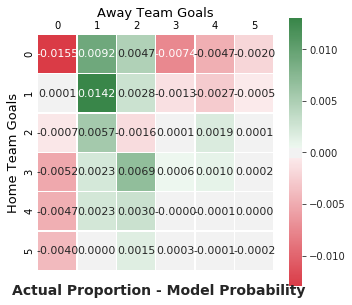

In [0]:
#Colourmap used to show estimation abilities of a simple Poisson model
cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))  
with sns.axes_style("white"):
    ax = sns.heatmap(np.mean(year_arrays, axis=0), annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(which='major', axis='both', linestyle='')
    ax.set_xlabel('Away Team Goals', fontsize=13)
    ax.set_ylabel('Home Team Goals', fontsize=13)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.figtext(0.45, 0.1, 'Actual Proportion - Model Probability', horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
plt.tight_layout()
plt.show()

As mentioned, it is evident that low scoring games are either overestimated or underestimated by the poisson model.

#### Defining the Poisson model to include Attacking and Defensive Strengths

We can formulate the model in mathematical terms:

$$ P(X_{i,j} = x, Y_{j,i} = y) = \frac{e^{-\lambda}\lambda^{x}}{x!} \frac{e^{-\mu}\mu^{y}}{y!} $$

Where: $$ \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i $$

In this equation, $i$ and $j$ refer to the home and away teams, respectively; $α$ and $β$ denote each team’s attack and defensive strength, respectively, while $γ$ represents the home advantage factor. So, we need to calculate $α$ and $β$ for each team, as well as $γ$ (the home field advantage term- it’s the same value for every team).

#### The Dixon-Coles Model

As mentioned ealier, the simple poisson model is not as effective in predicting low scoring games. To improve this, Dixon and Coles suggested to add a correction to the model. It can be written in these mathematical terms:

$$ P(X_{i,j} = x, Y_{j,i} = y) = \tau_{\lambda, \mu}(x, y) \frac{e^{-\lambda}\lambda^{x}}{x!} \frac{e^{-\mu}\mu^{y}}{y!} $$

Where: $$ \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i $$

$$\\ \tau_{\lambda, \mu}(x, y) = \begin{cases} 1 - \lambda \mu \rho & \text{if $x = y = 0$} \\ 1 - \lambda \rho & \text{if $x=0$, $y=1$} \\ 1 + \mu \rho & \text{if $x=0$, $y=1$} \\ 1 - \rho & \text{if $x = y = 1$} \\ 1 & \text{otherwise} \\ \end{cases}$$

Dixen and Coles found that in low scoring games, the number of goals scored by the two teams are not entirely independent. For low scoring games, it is seen that home team goals is dependent of away team goals and vice versa. 

They proposed to add the $τ$ (tau) function, which changes in value according to the score of the match. It is highly dependent on the $ρ$ (rho) parameter, which controls the strength of the correction (note: setting $ρ$ =0 equates to the standard BP model).

In [0]:
# Adding Rho correction to use Dixon-Coles Model

def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

Parameter Calculation

In order to find the Poisson model that best fits the data, we need to carry out a Maximum Likelihood Estimation procedure, to find the optimal model parameters.

There are attack parameters, $α_{1}, ..., α_{n}$ and defence parameters, $β_{1},..., β_{n}$, to accound for all $n$ teams. There is also the home parameter $\gamma$ and the Dixon-Coles parameter $\rho$.

To prevent over-parameterisation,  Dixon and Coles imposed that the average attacking strength parameter is equal to 1. This can be written as:

$$\frac{1}{n}\sum{}^n_{i=1}\alpha_i = 1$$

For the English Premier League (EPL), there are 42 parameters; there are two strength parameters for all 20 teams with an addition of the home advantage and Dixon-Coles parameters.

Using the log-likelihood function, these parameters can be estimated. The log-likelihood function for a set of matches $k = 1, ..., N,$ with
scores for each match ($x_k$, $y_k$) is given by:

$$LL(\alpha_1,...,\alpha_n,\beta_1,...,\beta_n,\gamma,\rho) = \sum^N_{k=1}\ln(\tau_{\lambda_{k},\mu_{k}}(x_k,y_k))-\lambda_{k}+ {x_k}\ln(\lambda_k) -\mu_{k} + {y_k}\ln(\mu_{k})$$

Where, 

$$\lambda_k = \alpha_{i(k)}\beta_{j(k)}\gamma,$$
$$\mu_k = \alpha_{j(k)}\beta_{i(k)} $$


Where $i(k)$ and $j(k)$ are id’s for the
home and away teams of match $k$.

We can add a modification to this likelihood function by introducing a fade factor which reduces the importance of older matches. This is required because generally, the quality of teams changes drastically over time. A good example of this is Manchester City who has risen to become a dominant team in the league,however in 2008/09 were not performing at that calibre. Therefore, it does not seem wise to use earlier data with the same importance as recent data to determine future performances. This gives us the following updated log-likelihood function:

$$LL(\alpha_1,...,\alpha_n,\beta_1,...,\beta_n,\gamma,\rho) = \sum^N_{k=1}\phi (t-t_{k})\Big (\ln(\tau_{\lambda_{k},\mu_{k}}(x_k,y_k))-\lambda_{k}+ {x_k}\ln(\lambda_k) -\mu_{k} + {y_k}\ln(\mu_{k})\Big )$$

where, Dixon-Coles have suggested to use: 

$$\phi (t-t_{k}) = e^{-\epsilon(t-t_{k})} $$

Using this $φ$ will downgrade the history matches exponentially. The value of $\epsilon$ determines by how much the importance of previous data varies. For example when  $\epsilon$ = 0 all matches
will be weighted equally. However, increasing the $\epsilon$ value will weight recent matches higher.

The nature of the fade function makes it impossible optimize it using the maximum
likelihood measure. Instead it will be estimated deterministically, with regards to the
assessments made by the model on over/under outcomes.





Optimising Local Parameters

Maximum Likelihood Estimation requires the log-likelihood function to be maximised. This can be done using gradient descent. In order to do this, the log-likelihood function must be derived to find the partial derivatives with respect to $\alpha_{i}$, $\beta_{i}$, $\gamma$, and $\rho$. 

The partial derivatives can be found [in this source](https://projekter.aau.dk/projekter/files/14466581/AssessingTheNumberOfGoalsInSoccerMatches.pdf#page=61) on pages 49 and 50.

In order to carry out the gradient descent, the method laid out by [Olesen](https://projekter.aau.dk/projekter/files/14466581/AssessingTheNumberOfGoalsInSoccerMatches.pdf#page=63) on page 51 of his report (which was written in pseudocode) was reproduced in python.

In [0]:
#Find the total number of unique teams in the EPL
Teams = np.unique(data.loc[0:4388,:].HomeTeam)
n_teams = len(Teams)

#values = pd.DataFrame
#The values vector, holds values which need to be found to maximise the likelihood:
# All entries in values is set to 1, except the last entry which is set to 1.4.
strengthscoreboard = pd.DataFrame(np.ones(((n_teams*2+2),(12))),columns = [x for x in range(2008,2020)])
values = np.concatenate((np.ones(n_teams),np.ones(n_teams), np.array([1,1.4])))

for i in range(2008,2020):
  strengthscoreboard.loc[:,i] = values
strengthscoreboard

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
72,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
73,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
#Set the resultant vector to be zero, to ensure no carry over during reruns.
output = 0
#N = data.shape[0] - 1

#There are 37 unique teams

for k in range(0,n_teams):
  #seperate the values vector into either strengths, gamma or rho, to simplify code.
  alpha = values[0:n_teams]
  beta = values[n_teams:(n_teams*2)]
  gamma = values[n_teams*2]
  rho = values[n_teams*2+1]

  lambda_k = alpha[np.where(Teams == data.HomeTeam[k])[0][0]] * beta[np.where(Teams == data.AwayTeam[k])[0][0]] * gamma
  mu_k = alpha[np.where(Teams == data.AwayTeam[k])[0][0]] * beta[np.where(Teams == data.HomeTeam[k])[0][0]]


In [0]:
n_teams

37

In the cell below, we define functions to be later used to predict the Attack and Defense Strength using the Poisson model.

In [0]:
# Optimising for the parameters using gradient descent
def Optimise(Matches, vals,eps):
 
  vals = np.concatenate((np.ones(n_teams),np.ones(n_teams), np.array([1,0.9])))
  gradient,normal,last_vals = vals,vals,vals
  N = Matches.shape[0] - 1

  #Creating functions for the parameters to simplify the code in order to be recalled later

  def TimeDecay(gameid):
    return np.exp(-(0.007)*(int((Matches.Date[Matches.shape[0]-1]-Matches.Date[gameid]).days)))

  def AlphaHome(gameid,alpha):
    return alpha[np.where(Teams == Matches.HomeTeam[gameid])[0][0]]

  def AlphaAway(gameid,alpha):
    return alpha[np.where(Teams == Matches.AwayTeam[gameid])[0][0]]

  def BetaHome(gameid,beta):
    return beta[np.where(Teams == Matches.HomeTeam[gameid])[0][0]]

  def BetaAway(gameid,beta):
    return beta[np.where(Teams == Matches.AwayTeam[gameid])[0][0]]

  def Lambdak(gameid,alpha,beta,gamma):
    return AlphaHome(gameid,alpha) * BetaAway(gameid,beta) * gamma

  def Muk(gameid,alpha,beta):
    return AlphaAway(gameid,alpha) * BetaHome(gameid,beta)
    
  def SeperateABGR(values):
    alpha = values[0:n_teams]
    beta = values[n_teams:(n_teams*2)]
    gamma = values[n_teams*2]
    rho = values[n_teams*2+1]
    return alpha, beta, gamma, rho
  #todo
  def LL(values,data):#matches
    output = 0
    
    for k in range(0,N):
      time_decay = TimeDecay(k)
      
      #seperate values into strengths, gamma and rho
      alpha, beta, gamma, rho = SeperateABGR(values)

      lambda_k = Lambdak(k,alpha,beta,gamma)
      mu_k = Muk(k,alpha,beta)
      #^pulling upon alphabetical placements of the teams

      x_k = data.HFTG[k]
      y_k = data.AFTG[k]

      if (x_k == 0) and (y_k == 0):
        tau = 1-lambda_k*mu_k*rho
      elif (x_k == 0) and (y_k == 1):
        tau = 1 + lambda_k*rho
      elif (x_k == 1) and (y_k == 0):
        tau = 1 + mu_k*rho
      elif (x_k == 1) and (y_k == 1):
        tau = 1 - rho
      else:
        tau = 1
            
      output += time_decay*((np.log(tau)) - lambda_k + x_k*np.log(lambda_k) - mu_k + y_k*np.log(mu_k))

    #end for
    return output
  
  def dLL_alpha(team_id):
    output = 0
    for k in range(0,N):
      time_decay = TimeDecay(k)
      
      #seperate values into strengths, gamma and rho
      alpha, beta, gamma, rho = SeperateABGR(values)

      lambda_k = Lambdak(k,alpha,beta,gamma)
      mu_k = Muk(k,alpha,beta)
      #^pulling upon alphabetical placements of the teams

      x_k = Matches.HFTG[k]
      y_k = Matches.AFTG[k]

      home_id = np.where(Teams == Matches.HomeTeam[k])[0][0]
      away_id = np.where(Teams == Matches.AwayTeam[k])[0][0]

      alpha_h = AlphaHome(k,alpha)
      alpha_a = AlphaAway(k,alpha)
      beta_h = BetaHome(k,beta)
      beta_a = BetaAway(k,beta)

      if (team_id != home_id) and (team_id != away_id):
        output += 0
      elif (team_id == home_id) and (x_k == 0) and (y_k == 0):
        output += time_decay*((-beta_a*mu_k*gamma*rho)/(1-lambda_k*mu_k*rho) -beta_a*gamma + (x_k)/(alpha_h))
      elif (team_id == home_id) and (x_k == 0) and (y_k == 1):
        output += time_decay*((beta_a*gamma*rho)/(1+lambda_k*rho) -beta_a*gamma + (x_k)/(alpha_h))
      elif (team_id == home_id) and (x_k != 0) and (y_k != 0) and (y_k != 1):
        output += time_decay*(-beta_a*gamma + (x_k)/(alpha_h))
      elif (team_id == away_id) and (x_k == 0) and (y_k == 0):
        output += time_decay*((-beta_h*lambda_k*gamma*rho)/(1-lambda_k*mu_k*rho) -beta_h*gamma + (y_k)/(alpha_a))
      elif (team_id == away_id) and (x_k == 1) and (y_k == 0):
        output += time_decay*((beta_h*rho)/(1+mu_k*rho) -beta_h + (y_k)/(alpha_a))
      elif (team_id == away_id) and (x_k != 0) and (x_k != 1) and (y_k != 0):
        output += time_decay*(-beta_h + (y_k)/(alpha_a))
    
    #end for
    return output

  def dLL_beta(team_id):
    output = 0
    for k in range(0,N):
      time_decay = TimeDecay(k)
      
      #seperate values into strengths, gamma and rho
      alpha, beta, gamma, rho = SeperateABGR(values)

      lambda_k = Lambdak(k,alpha,beta,gamma)
      mu_k = Muk(k,alpha,beta)
      #^pulling upon alphabetical placements of the teams

      x_k = Matches.HFTG[k]
      y_k = Matches.AFTG[k]

      home_id = np.where(Teams == Matches.HomeTeam[k])[0][0]
      away_id = np.where(Teams == Matches.AwayTeam[k])[0][0]

      alpha_h = AlphaHome(k,alpha)
      alpha_a = AlphaAway(k,alpha)
      beta_h = BetaHome(k,beta)
      beta_a = BetaAway(k,beta)

      if (team_id != home_id) and (team_id != away_id):
        output += 0
      elif (team_id == home_id) and (x_k == 0) and (y_k == 0):
        output += time_decay*((-lambda_k*alpha_a*rho)/(1-lambda_k*mu_k*rho) - alpha_a + (y_k)/(beta_h))
      elif (team_id == home_id) and (x_k == 1) and (y_k == 0):
        output += time_decay*((alpha_a*rho)/(1+mu_k*rho) -alpha_a + (y_k)/(beta_h))
      elif (team_id == home_id) and (x_k != 0) and (x_k != 1) and (y_k != 0):
        output += time_decay*(-alpha_a + (y_k)/(beta_h))
      elif (team_id == away_id) and (x_k == 0) and (y_k == 0):
        output += time_decay*((-alpha_h*mu_k*gamma*rho)/(1-lambda_k*mu_k*rho) - alpha_h*gamma + (x_k)/(beta_a))
      elif (team_id == away_id) and (x_k == 0) and (y_k == 1):
        output += time_decay*((alpha_h*gamma*rho)/(1+lambda_k*rho) - alpha_h*gamma + (x_k)/(beta_a))
      elif (team_id == away_id) and (x_k != 0) and (y_k != 0) and (y_k != 1):
        output += time_decay*(- alpha_h*gamma + (x_k)/(beta_a))
    
    #end for
    return output

  def dLL_rho():
    output = 0
    for k in range(0,N):
      time_decay = TimeDecay(k)
      
      #seperate values into strengths, gamma and rho
      alpha, beta, gamma, rho = SeperateABGR(values)

      lambda_k = Lambdak(k,alpha,beta,gamma)
      mu_k = Muk(k,alpha,beta)
      #^pulling upon alphabetical placements of the teams

      x_k = data.HFTG[k]
      y_k = data.AFTG[k]

      if (x_k == 0) and (y_k == 0):
        output += time_decay*((-lambda_k*mu_k)/(1-lambda_k*mu_k*rho))
      elif (x_k == 0) and (y_k == 1):
        output += time_decay*((lambda_k)/(1+lambda_k*rho))
      elif (x_k == 1) and (y_k == 0):
        output += time_decay*((mu_k)/(1+mu_k*rho))
      elif (x_k == 1) and (y_k == 1):
        output += time_decay*((-1)/(1-rho))
      elif (x_k != 0) and (x_k != 1) and (y_k != 0) and (y_k != 1):
        output += 0
    
    return output
  #
  def dLL_gamma():
    output = 0
    for k in range(0,N):
      time_decay = TimeDecay(k)
      
      #seperate values into strengths, gamma and rho
      alpha, beta, gamma, rho = SeperateABGR(values)

      lambda_k = Lambdak(k,alpha,beta,gamma)
      mu_k = Muk(k,alpha,beta)
      #^pulling upon alphabetical placements of the teams

      x_k = Matches.HFTG[k]
      y_k = Matches.AFTG[k]

      alpha_h = AlphaHome(k,alpha)
      alpha_a = AlphaAway(k,alpha)
      beta_h = BetaHome(k,beta)
      beta_a = BetaAway(k,beta)

      if (x_k == 0) and (y_k == 0):
        output += time_decay*((-alpha_h*beta_a*mu_k*rho)/(1-lambda_k*mu_k*rho) - alpha_h*beta_a + (x_k)/(gamma))
      elif (x_k == 0) and (y_k == 1):
        output += time_decay*((alpha_h*beta_a*rho)/(1+lambda_k*rho) - alpha_h*beta_a + (x_k)/(gamma))
      elif (x_k != 0) and (y_k != 0) and (y_k != 1):
        output += time_decay*(- alpha_h*beta_a + (x_k)/(gamma))

    return output

  #return dLL_gamma()
  iters = 0
  while np.linalg.norm(last_vals-vals) < 0.001:
    iters += 1
    last_vals = vals
    for team_id in range(0,n_teams):
      gradient[team_id] = dLL_alpha(team_id) 
      gradient[team_id + n_teams] = dLL_beta(team_id)
    #end for
    gradient[(n_teams*2)] = dLL_gamma()
    gradient[(n_teams*2)+1] = dLL_rho()
    
    alpha_mean = np.mean(vals[0:n_teams])
    for i in range(0,n_teams):
      normal[i] = alpha_mean
      normal[i+n_teams] = 0
    #end for
    normal[(n_teams*2)] = 0
    normal[(n_teams*2)+1] = 0

    gradient = gradient - normal
    PresentPoint = vals
    StepToPoint = vals + gradient

    while LL(StepToPoint,Matches) > LL(PresentPoint,Matches):
      PresentPoint = StepToPoint
      StepToPoint += gradient  
    vals = (PresentPoint + StepToPoint)/2

  return vals, iters


In [0]:
data

,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR
0,2008-08-16,Arsenal,West Brom,1,0,H
1,2008-08-16,Bolton,Stoke,3,1,H
2,2008-08-16,Everton,Blackburn,2,3,A
3,2008-08-16,Hull,Fulham,2,1,H
4,2008-08-16,Middlesbrough,Tottenham,2,1,H
...,...,...,...,...,...,...
4384,2020-01-01,Man City,Everton,2,1,H
4385,2020-01-01,Norwich,Crystal Palace,1,1,D
4386,2020-01-01,West Ham,Bournemouth,4,0,H
4387,2020-01-01,Arsenal,Man United,2,0,H


The below gradient descent for each season n takes into account the data from all seasons before and including n. The data takes ~40 mins to run, so we have used the markdown code below to create a csv of all the attack and defense strengths of the 37 teams that have played since 2008. The last two rows represent gamma and rho defined in the poisson model. After creating the csv, we have uploaded the result to github which can be extracted easily. 

In [0]:
#for i in range(2008,2019):
#  tot_iters = 0
#  #opt_vals, tot_iters = Optimise(data.loc[0:3799,:],0.007)
#  opt_vals,tot_iters = Optimise(data.loc[0:((i-2007)*380-1),:],strengthscoreboard.loc[:,i],0.007)
#  strengthscoreboard.loc[:,i] = opt_vals

In [0]:
#strengthscoreboardsave1 = strengthscoreboard.copy()

In [0]:
#opt_vals,tot_iters = Optimise(data.loc[:,:],strengthscoreboard.loc[:,2019],0.007)
#strengthscoreboard.loc[:,2019] = opt_vals
#strengthscoreboard
#strength_labels = np.concatenate((["attack_" for x in range(0,n_teams)]+Teams, ["defense_" for x in range(0,n_teams)]+Teams, ["gamma"], ["rho"] ), axis =0)
#strengthscoreboard.index = strength_labels
#strengthscoreboard

In [0]:
#strengthscoreboardsave2 = strengthscoreboard.copy()

In [0]:
#from google.colab import files
#strengthscoreboard.to_csv('scoreboard1.csv',index=False)

#files.download("scoreboard1.csv")

#### Attack and Defense Strength of Teams



For the calculated attack and defense strengths, we extract the data from the previously calculated csv on github, and organise it to be used in our prediction model as below:

In [0]:
strengthscoreboard = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/scoreboard1.csv')
strengthscoreboard
strength_labels = np.concatenate((["attack_" for x in range(0,n_teams)]+Teams, ["defense_" for x in range(0,n_teams)]+Teams, ["gamma"], ["rho"] ), axis =0)
strengthscoreboard.index = strength_labels
strengthscoreboard

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
attack_Arsenal,7.202505,6.384986,7.326830,8.181267,7.292959,4.075552,4.435387,7.073772,3.741783,4.834887,3.075411e+00,4.503609e+00
attack_Aston Villa,6.319909,6.845444,4.316015,7.574620,4.838240,5.989796,4.639060,5.082269,2.028620,1.723267,1.447896e+00,2.539931e+00
attack_Birmingham,1.820112,4.781879,3.713115,1.988973,2.288043,1.743940,1.626657,1.918707,1.789622,1.703629,1.446359e+00,1.140323e+00
attack_Blackburn,5.762650,7.555234,4.949211,4.505233,2.475497,1.759342,1.627750,1.918795,1.789629,1.703630,1.446359e+00,1.140323e+00
attack_Blackpool,1.820112,2.131968,6.928451,2.253168,2.307725,1.745557,1.626772,1.918716,1.789623,1.703629,1.446359e+00,1.140323e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
defense_West Ham,1.933383,4.392706,4.382268,0.360078,4.524373,3.102344,2.265438,4.749193,4.696260,3.395951,1.838380e+00,2.257596e+00
defense_Wigan,3.430109,3.975192,4.356578,1.852203,3.166726,0.301284,0.021371,0.001732,0.000131,0.000011,8.409777e-07,1.623193e-07
defense_Wolves,0.000000,4.564302,1.577543,5.759578,0.503566,0.041377,0.002935,0.000238,0.000018,0.000001,1.545803e+00,3.002473e+00
gamma,35.791740,42.809086,37.265604,35.489211,42.980605,32.611753,30.498497,37.627009,36.386101,32.832018,2.862748e+01,2.246504e+01


### **Elo Rating System**


In the cell below, we extract the clean data once again to preprocess with specific use for the Elo Rating System.





In [0]:
#defining a function to call clean data from the epl-training.csv
def dataload(end):
  X = pd.read_csv(data_source)

  X = X.iloc[:,:22]
  X.columns = ["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR", "HHTG", "AHTG", "HTR", "Referee", "HSoG", "ASoG", "HSoT","ASoT","HFouls","AFouls", "HCorners", "ACorners", "HYellows", "AYellows", "HReds", "AReds"]
  X.Date = pd.to_datetime(X.Date,dayfirst=True)
  y = X.FTR
  
  #Isolate Primary Attributes
  X = X.loc[:,["Date", "HomeTeam", "AwayTeam", "HFTG", "AFTG", "FTR", "HHTG", "AHTG"]]

  #2019 data import
  data_2019 = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/2019-2020.csv')

  data_2019.Date = pd.to_datetime(data_2019.Date,dayfirst=True)
  data_2019 = data_2019.loc[:,['Date', 'HomeTeam', 'AwayTeam','FTHG','FTAG','FTR', 'HTHG', 'HTAG','HS','AS','HST','AST']]
  data_2019.columns = ['Date', 'HomeTeam', 'AwayTeam','HFTG','AFTG','FTR', 'HHTG', 'AHTG','HSoG','ASoG','HSoT','ASoT']
  data_2019 = data_2019.loc[:,['Date', 'HomeTeam', 'AwayTeam','HFTG','AFTG','FTR','HHTG','AHTG']]

  X = X.append(data_2019,ignore_index=True)
  
  X = X.loc[0:end,:]
  y = X.FTR

  return X,y

X,y = dataload(4388)
data = X.copy()
#data #can use this to check recieved data is correct

The Elo rating system is used throughout sport ranging from NFL to chess and can be applied to football. It is a system for relative valuation of the strength of a team and can produce a rating system based on a team’s Elo score. The system assumes that the initial strengths of the teams are the same and adjusts based on the full-time result of the games. Each team starts with the same rating of 1500, and as the seasons progress, the ratings change depending on the final score of each game. Teams gain Elo points from victories and loses points after losses. The formula inherently considers “upset wins”, which will grant the winning weaker team a lot more Elo points than if the stronger team won (as predicted through ranking). 

The Elo formula that we’ve used, is as below:
$ \hspace{0.2cm} R_{new}= R_{old}+MOV \times (S_a-E)$

Where the $S_a$ is the actual score, E is the expected score and MOV is a constant that is defined based on N, the absolute value of goal difference of the result :

$$
MOV =
\begin{cases}
1 \hspace{0.2cm} \textrm{if} \hspace{0.2cm}N  \leq 1,\\
1.5 \hspace{0.2cm} \textrm{if} \hspace{0.2cm}N = 2\\
\frac{N + 11}{8}\hspace{0.2cm} \textrm{if} \hspace{0.2cm} N \geq 3
\end{cases}
$$


In [0]:
#Code for assigning team ID, need to work on individual assignment instead of column assignment

teams = np.unique(data.HomeTeam)
team_ID = {}                               #assigning unique ID to team for the season
for ii in range(0,teams.shape[0]):
    team_ID[ii] = teams[ii]
print(team_ID)

l=[]                                      #list for unique ID for home team
m= []                                     #list for unique ID for away team

for ii in data.HomeTeam:
    for k in team_ID:
        if ii == team_ID[k]:
            l.append(k)

l=np.asarray(l)


for ii in data.AwayTeam:
    for k in team_ID:
        if ii ==team_ID[k]:
            m.append(k)
            
m = np.asarray(m)
            
data['HomeTeam_ID'] = l
data['AwayTeam_ID'] = m

display(data.head(10)) #used to check Team_ID has been assigned correctly

{0: 'Arsenal', 1: 'Aston Villa', 2: 'Birmingham', 3: 'Blackburn', 4: 'Blackpool', 5: 'Bolton', 6: 'Bournemouth', 7: 'Brighton', 8: 'Burnley', 9: 'Cardiff', 10: 'Chelsea', 11: 'Crystal Palace', 12: 'Everton', 13: 'Fulham', 14: 'Huddersfield', 15: 'Hull', 16: 'Leicester', 17: 'Liverpool', 18: 'Man City', 19: 'Man United', 20: 'Middlesbrough', 21: 'Newcastle', 22: 'Norwich', 23: 'Portsmouth', 24: 'QPR', 25: 'Reading', 26: 'Sheffield United', 27: 'Southampton', 28: 'Stoke', 29: 'Sunderland', 30: 'Swansea', 31: 'Tottenham', 32: 'Watford', 33: 'West Brom', 34: 'West Ham', 35: 'Wigan', 36: 'Wolves'}


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,0,33
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,5,28
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,12,3
3,2008-08-16,Hull,Fulham,2,1,H,1,1,15,13
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,20,31
5,2008-08-16,Sunderland,Liverpool,0,1,A,0,0,29,17
6,2008-08-16,West Ham,Wigan,2,1,H,2,0,34,35
7,2008-08-17,Aston Villa,Man City,4,2,H,0,0,1,18
8,2008-08-17,Chelsea,Portsmouth,4,0,H,3,0,10,23
9,2008-08-17,Man United,Newcastle,1,1,D,1,1,19,21


Our goal is to create a scoreboard to display each team's Elo Rating at a given season.

In [0]:
# Team_rating Scoreboard
# This cell initialises scoreboard
teams = list(teams)
scoreboard = pd.DataFrame(teams)
scoreboard.columns = ['Teams']
scoreboard['Team_ID'] = team_ID
scoreboard['Initial_Elo'] = 1500

Defining the functions to be used in our Elo Rating System Calculation:

In [0]:
def scoreboard_update(current_season, elo_dict):
    #This cell deals with how to automatically append the scoreboard based on the season input
    
    sorted_elo_dict = sorted(elo_dict.items(), key=operator.itemgetter(1),reverse=True)       #sort the dictionary to get ranking

    last_three_average = sum(heapq.nsmallest(3, list(elo_dict.values())))/3                   #computes the average of the last three values
    scoreboard[current_season] = last_three_average
    scoreboard.loc[scoreboard['Teams'].isin(season_teams),current_season] =list(elo_dict.values())    #Checks if teams is in current-season if yes, then changes the values accordingly

In [0]:
yindex = 380*(np.arange(0,12))                  #holds the beginning and final rows for a particular season

#function for separating data into different seasons
def season_select(begin_season_year):
    search_index = begin_season_year - 2008
    rs = data.iloc[yindex[search_index]:yindex[search_index+1],:]
    return rs
    

In our Elo Rating system, we have included a home-court advantage of 100 Elo rating points. Home teams are traditionally more favoured to win, due to a mixture of factors including a stronger fan base and less travel time. This was shown in our initial data exploration. The numerical value of 100 has been chosen as it was a standard within online prediction models. Nate Silver has experimented with dynamic home-court advantage rating for the NBA, which changes the magnitude of the advantage over time, but it was found that almost no difference could be made to the overall ratings. 

We also added an attribute which takes into the ‘streak’ result. The aim of this is to mimic the last 5 previous match results which is similar and derived from the EPL’s ‘last 5’ result. We see it as a method to measure team morale. Winning takes a value of 100, while 50 and 10 are for a draw and a loss respectively. A streak average of 100 represents the highest morale, and that is reflected if the team has won the last 5 matches. A streak average of 10 represents the exact opposite of losing past 5 matches. Within our notebook, it is calculated by finding the average result of the last 5 games, and the streak is updated after every match, matching the iteration of the Elo Rating system.

Our modified expected result formula is as shown:   
<br> 

$E = \frac{1}{1+10^{\left(R_H + 100+ H_S - R_A - A_S\right)/400}}$

*Where $R_H$ and $R_A$ are the home and away rating respectively and $H_S$ and $A_S$ are the home and away streak average value respectively.*  
<br>


As seasons change, players often shift through transfers between different clubs, but football teams have been consistent year to year. Instead of resetting each team’s rating, three-quarters of the old team rating is carried forward, while the remaining quarter comes from the average of 1500 . This is done using the following formula:
<br>  
$R_n=(0.75\ \times\ R_{n-1})+(0.25\ \times\ 1500)$

*Where $R_n$ is the ranking of a team in a given season n.*    
<br>
A distinct feature of football leagues compared to other sports is that relegation and promotion of teams occur. This varies the 20 teams that play in the EPL in a given season. To adjust for this change, we take into account that the Elo rating system is zero-sum, thus the average rating points over different seasons should not change. To account for relegation, we have taken the average of the Elo rating points of the last three teams in our system and assigned such average to the three promoted teams. This follows from the assumption and trend that promoted teams, coming from a less competitive division, would have similar levels of playing with respect to relegated teams.

In [0]:
# Elo System Rating
for current_season in range(2008,2020):
    
    if current_season < 2019:
      rs = season_select(current_season) #get the values of one season
    else:
      #search_index = begin_season_year - 2008
      rs = data.iloc[4180:4388,:] 
    
    #get the value of one season
    display(rs.head())
    season_teams = np.unique(rs.HomeTeam)
    #print(season_teams)             

    pen_elo_dict = scoreboard[scoreboard['Teams'].isin(season_teams)]
    last_season_index = current_season - 2006                # 2006 because to get the correct index
    
    #The following two expressions deals with year-to-year carry over
    carried_over_elo = pen_elo_dict.iloc[:,last_season_index]*0.75 +0.25*1500         
    elo_dict = dict(zip(list(season_teams),carried_over_elo))
    #print(elo_dict)
    ###################################################
    #Initialise streak dictionary for every season
    #All the 
    last_five_result = (np.ones((len(season_teams),5))*10).tolist()
    streak_dict = dict(zip(season_teams,last_five_result))

    preds = []
    w_elo =[]
    l_elo = []
    hadv = 100

    def expected_margin(mov):
        if mov <=1:
            return 1
        elif mov ==2:
            return 2
        else:
            return ((mov+11)/8)

    
    #Loop over all rows of the games dataframe
    count = 0
    team_count = 0
    for row in rs.itertuples():
        #Get key data from current row
        count+=1                #number of times the code has been run
    
        if row.FTR =='H':
            w = row.HomeTeam
            l = row.AwayTeam
            actual_result = 1
            ###################################################
            #This section extracts streak list
            ws_rating = streak_dict[w]                               #win streak rating
            ws_avg = sum(ws_rating)/len(ws_rating)
            ls_rating = streak_dict[l]                               #lose streak rating
            ls_avg = sum(ls_rating)/len(ls_rating)
            ###################################################
            ###################################################
            #This section updates the streak list
            del ws_rating [-1]
            ws_rating.insert(0,100)
            streak_dict[w] = ws_rating
        
            del ls_rating [-1]
            ls_rating.insert(0,10)
            streak_dict[l] = ls_rating
            ##################################################
            
        elif row.FTR =='A':
            w =row.AwayTeam
            l =row.HomeTeam
            actual_result = 0
            
            ###################################################
            #This section extracts streak list
            ws_rating = streak_dict[w]                               #win streak rating
            ws_avg = sum(ws_rating)/len(ws_rating)
            ls_rating = streak_dict[l]                               #lose streak rating
            ls_avg = sum(ls_rating)/len(ls_rating)
            ################################################### 
            ###################################################
            #This section updates the streak list
            del ws_rating [-1]
            ws_rating.insert(0,100)
            streak_dict[w] = ws_rating
        
            del ls_rating [-1]
            ls_rating.insert(0,10)
            streak_dict[l] = ls_rating
            ##################################################
        else:                   
            w =row.HomeTeam
            l =row.AwayTeam
            actual_result = 0.5
            
            ###################################################
            #This section extracts streak list
            ws_rating = streak_dict[w]                               #win streak rating
            ws_avg = sum(ws_rating)/len(ws_rating)
            ls_rating = streak_dict[l]                               #lose streak rating
            ls_avg = sum(ls_rating)/len(ls_rating)
            ###################################################
            ###################################################
            #This section updates the streak list
            del ws_rating [-1]
            ws_rating.insert(0,50)
            streak_dict[w] = ws_rating
        
            del ls_rating [-1]
            ls_rating.insert(0,50)
            streak_dict[l] = ls_rating
            ##################################################
        
        
        margin = abs(row.HFTG -row.AFTG)
  
    
        win_elo = elo_dict[w]
        lose_elo = elo_dict[l]
    
        #Main Elo Formula
        #05/01/2020
        pred = 1/(1 +10**(-(win_elo + hadv +ws_avg -ls_avg - lose_elo)/400))              #main Elo rating prediction formula
  
                    
        #winning team ranking update
        elo_dict[w]+=expected_margin(margin)*abs(actual_result-pred)     

    
        #losing team ranking update
        elo_dict[l]-=expected_margin(margin)*abs(actual_result-pred) 
        #print('Updated ranking of ',l,' is', elo_dict[l])
    
        #Saving prediction and new Elos for each round
        preds.append(pred)
        w_elo.append(elo_dict[w])
        l_elo.append(elo_dict[l])
    
    #call function to update scoreboard
    scoreboard_update(str(current_season), elo_dict)

,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,0,33
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,5,28
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,12,3
3,2008-08-16,Hull,Fulham,2,1,H,1,1,15,13
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,20,31


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
380,2009-08-15,Aston Villa,Wigan,0,2,A,0,1,1,35
381,2009-08-15,Blackburn,Man City,0,2,A,0,1,3,18
382,2009-08-15,Bolton,Sunderland,0,1,A,0,1,5,29
383,2009-08-15,Chelsea,Hull,2,1,H,1,1,10,15
384,2009-08-15,Everton,Arsenal,1,6,A,0,3,12,0


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
760,2010-08-14,Aston Villa,West Ham,3,0,H,2,0,1,34
761,2010-08-14,Blackburn,Everton,1,0,H,1,0,3,12
762,2010-08-14,Bolton,Fulham,0,0,D,0,0,5,13
763,2010-08-14,Chelsea,West Brom,6,0,H,2,0,10,33
764,2010-08-14,Sunderland,Birmingham,2,2,D,1,0,29,2


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
1140,2011-08-13,Blackburn,Wolves,1,2,A,1,1,3,36
1141,2011-08-13,Fulham,Aston Villa,0,0,D,0,0,13,1
1142,2011-08-13,Liverpool,Sunderland,1,1,D,1,0,17,29
1143,2011-08-13,Newcastle,Arsenal,0,0,D,0,0,21,0
1144,2011-08-13,QPR,Bolton,0,4,A,0,1,24,5


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
1520,2012-08-18,Arsenal,Sunderland,0,0,D,0,0,0,29
1521,2012-08-18,Fulham,Norwich,5,0,H,2,0,13,22
1522,2012-08-18,Newcastle,Tottenham,2,1,H,0,0,21,31
1523,2012-08-18,QPR,Swansea,0,5,A,0,1,24,30
1524,2012-08-18,Reading,Stoke,1,1,D,0,1,25,28


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
1900,2013-08-17,Arsenal,Aston Villa,1,3,A,1,1,0,1
1901,2013-08-17,Liverpool,Stoke,1,0,H,1,0,17,28
1902,2013-08-17,Norwich,Everton,2,2,D,0,0,22,12
1903,2013-08-17,Sunderland,Fulham,0,1,A,0,0,29,13
1904,2013-08-17,Swansea,Man United,1,4,A,0,2,30,19


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
2280,2014-08-16,Arsenal,Crystal Palace,2,1,H,1,1,0,11
2281,2014-08-16,Leicester,Everton,2,2,D,1,2,16,12
2282,2014-08-16,Man United,Swansea,1,2,A,0,1,19,30
2283,2014-08-16,QPR,Hull,0,1,A,0,0,24,15
2284,2014-08-16,Stoke,Aston Villa,0,1,A,0,0,28,1


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
2660,2015-08-08,Bournemouth,Aston Villa,0,1,A,0,0,6,1
2661,2015-08-08,Chelsea,Swansea,2,2,D,2,1,10,30
2662,2015-08-08,Everton,Watford,2,2,D,0,1,12,32
2663,2015-08-08,Leicester,Sunderland,4,2,H,3,0,16,29
2664,2015-08-08,Man United,Tottenham,1,0,H,1,0,19,31


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
3040,2016-08-13,Burnley,Swansea,0,1,A,0,0,8,30
3041,2016-08-13,Crystal Palace,West Brom,0,1,A,0,0,11,33
3042,2016-08-13,Everton,Tottenham,1,1,D,1,0,12,31
3043,2016-08-13,Hull,Leicester,2,1,H,1,0,15,16
3044,2016-08-13,Man City,Sunderland,2,1,H,1,0,18,29


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
3420,2017-08-11,Arsenal,Leicester,4,3,H,2,2,0,16
3421,2017-08-12,Brighton,Man City,0,2,A,0,0,7,18
3422,2017-08-12,Chelsea,Burnley,2,3,A,0,3,10,8
3423,2017-08-12,Crystal Palace,Huddersfield,0,3,A,0,2,11,14
3424,2017-08-12,Everton,Stoke,1,0,H,1,0,12,28


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
3800,2018-08-10,Man United,Leicester,2,1,H,1,0,19,16
3801,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,6,9
3802,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,13,11
3803,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,14,10
3804,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,21,31


,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,HomeTeam_ID,AwayTeam_ID
4180,2019-08-09,Liverpool,Norwich,4,1,H,4,0,17,22
4181,2019-08-10,West Ham,Man City,0,5,A,0,1,34,18
4182,2019-08-10,Bournemouth,Sheffield United,1,1,D,0,0,6,26
4183,2019-08-10,Burnley,Southampton,3,0,H,0,0,8,27
4184,2019-08-10,Crystal Palace,Everton,0,0,D,0,0,11,12


#### Final ELO Scoreboard Per Season


By iterating throughout each season, we can display the Elo Rating scoreboard for all the seasons, which displays the Elo rating of all the teams in a given season. A limitation within our code is that teams with repeated values for a given season (i.e. 1489.693 for 2008) are teams that did not play in that given season, and are assigned the average of the last three teams from the previous season. Further work could look at implementing a blank cell to be less confusing.

In [0]:
display(scoreboard)

,Teams,Team_ID,Initial_Elo,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Arsenal,0,1500,1512.060158,1520.324077,1524.704434,1526.875767,1530.613769,1538.292314,1540.356831,1540.166282,1542.224741,1533.727316,1533.650307,1525.089096
1,Aston Villa,1,1500,1506.412742,1512.675776,1507.186257,1498.988701,1494.013385,1487.461394,1482.935057,1469.157277,1467.708324,1469.106729,1460.824345,1467.306846
2,Birmingham,2,1500,1489.693150,1492.411905,1487.476217,1477.023110,1475.076054,1472.017492,1470.702724,1469.977562,1467.708324,1469.106729,1460.824345,1466.887339
3,Blackburn,3,1500,1494.177782,1494.022246,1492.925295,1483.115456,1475.076054,1472.017492,1470.702724,1469.977562,1467.708324,1469.106729,1460.824345,1466.887339
4,Blackpool,4,1500,1489.693150,1481.979281,1479.173579,1477.023110,1475.076054,1472.017492,1470.702724,1469.977562,1467.708324,1469.106729,1460.824345,1466.887339
5,Bolton,5,1500,1494.650645,1488.420111,1489.555657,1481.882044,1475.076054,1472.017492,1470.702724,1469.977562,1467.708324,1469.106729,1460.824345,1466.887339
6,Bournemouth,6,1500,1489.693150,1481.979281,1481.023632,1477.023110,1475.076054,1472.017492,1470.702724,1471.198529,1472.085338,1473.427328,1478.260899,1480.242042
7,Brighton,7,1500,1489.693150,1481.979281,1481.023632,1477.023110,1475.076054,1472.017492,1470.702724,1469.977562,1467.708324,1469.683486,1467.794637,1474.384855
8,Burnley,8,1500,1489.693150,1481.583919,1481.023632,1477.023110,1475.076054,1472.017492,1468.868524,1469.977562,1471.483329,1478.558756,1474.374859,1475.346367
9,Cardiff,9,1500,1489.693150,1481.979281,1481.023632,1477.023110,1475.076054,1468.099179,1470.702724,1469.977562,1467.708324,1469.106729,1465.979363,1466.887339


The code below can use to check the predicted Elo Ranking of a given year and can be cross referenced to the EPL standings.

In [0]:
scoreboard.loc[:,['Teams','Team_ID','2019']].sort_values(by=['2019'], ascending=False) # Change '2019' to the year of interest

,Teams,Team_ID,2019
18,Man City,18,1559.137296
17,Liverpool,17,1548.879689
10,Chelsea,10,1535.377467
19,Man United,19,1531.545299
31,Tottenham,31,1530.500766
0,Arsenal,0,1525.089096
16,Leicester,16,1505.938346
12,Everton,12,1499.870413
27,Southampton,27,1489.430026
34,West Ham,34,1489.224640


### Combining Elo and Poisson Strength Features into data

New dataload for prediction training set, where we incorporate the Elo and Poisson Strength into our data.

In [0]:
X,y=dataload(4389) # all games
X.shape

(4389, 8)

Here we look at finalising the feature selection to prepare for data cleaning followed by model training. Instead of taking the Home and Away Strengths we create a new feature - Strength Difference (SDiff). We do this through averaging the attacking and defensive strength of a given team, and for a given game we find the difference in strength average of the home and away team. Creating a new feature of strength difference (SDiff) allows us to minimise the risk of the curse of dimensionality. We went through a similar approach with the Elo Rating, where we took the difference (DeltaELO) as a feature, where DeltaELO is simply the difference in Elo rating between the home and away team.

Adding the DeltaELO and SDiff features in:

In [0]:
#Initiate New Attributes

col = ["HAS","HDS","AAS","ADS","SDiff","DeltaELO"]
new_attributes = pd.DataFrame(np.ones((X.shape[0],len(col))),columns=col)
X = pd.concat([X,new_attributes],axis = 1)
#Assign strengths
for i in range(0,X.shape[0]):
  X.HAS[i]=strengthscoreboard.loc['attack_'+X.HomeTeam[i],str((i//380)+2008)]
  X.HDS[i]=strengthscoreboard.loc['defense_'+X.HomeTeam[i],str((i//380)+2008)]
  X.AAS[i]=strengthscoreboard.loc['attack_'+X.AwayTeam[i],str((i//380)+2008)]
  X.ADS[i]=strengthscoreboard.loc['defense_'+X.AwayTeam[i],str((i//380)+2008)]
  X.SDiff[i] = ((X.HAS[i]+X.HDS[i])/2)-((X.AAS[i]+X.ADS[i])/2)
  #X.HAS,X.HDS,X.AAS,X.ADS = 0,0,0,0
#Assign strengths for blind test from penultimate season
#for i in range(X.shape[0]-380,X.shape[0]):
#  X.HAS[i]=strengthscoreboard.loc['attack_'+X.HomeTeam[i-380],str((i//380)+2007)]
#  X.HDS[i]=strengthscoreboard.loc['defense_'+X.HomeTeam[i-380],str((i//380)+2007)]
#  X.AAS[i]=strengthscoreboard.loc['attack_'+X.AwayTeam[i-380],str((i//380)+2007)]
#  X.ADS[i]=strengthscoreboard.loc['defense_'+X.AwayTeam[i-380],str((i//380)+2007)]
#  X.SDiff[i] = ((X.HAS[i]+X.HDS[i])/2)-((X.AAS[i]+X.ADS[i])/2)
#  #X.HAS,X.HDS,X.AAS,X.ADS = 0,0,0,0

X = X.drop(['HAS','HDS','AAS','ADS'],1)

for i in range(0,X.shape[0]):
  X.DeltaELO[i] = (scoreboard.loc[np.where(Teams == X.HomeTeam[i])[0][0],str((i//380)+2008)]) -(scoreboard.loc[np.where(Teams == X.AwayTeam[i])[0][0],str((i//380)+2008)])

#for i in range(X.shape[0]-380,X.shape[0]):
#  X.DeltaELO[i] = (scoreboard.loc[np.where(Teams == X.HomeTeam[i])[0][0],str((i//380)+2007)]) -(scoreboard.loc[np.where(Teams == X.AwayTeam[i])[0][0],str((i//380)+2007)])
clear_output()
X #Viewing data again

,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,SDiff,DeltaELO
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,1.248015,24.519650
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,2.138040,-1.436258
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,0.964299,12.494184
3,2008-08-16,Hull,Fulham,2,1,H,1,1,-1.803656,-11.126469
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,-1.740084,-7.592420
...,...,...,...,...,...,...,...,...,...,...
4384,2020-01-01,Man City,Everton,2,1,H,0,0,-2.251364,59.266883
4385,2020-01-01,Norwich,Crystal Palace,1,1,D,1,0,-0.616251,-23.133135
4386,2020-01-01,West Ham,Bournemouth,4,0,H,3,0,-0.523453,8.982598
4387,2020-01-01,Arsenal,Man United,2,0,H,2,0,1.712987,-6.456202


In [0]:
X

,Date,HomeTeam,AwayTeam,HFTG,AFTG,FTR,HHTG,AHTG,SDiff,DeltaELO
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,1.248015,24.519650
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,2.138040,-1.436258
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,0.964299,12.494184
3,2008-08-16,Hull,Fulham,2,1,H,1,1,-1.803656,-11.126469
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,-1.740084,-7.592420
...,...,...,...,...,...,...,...,...,...,...
4384,2020-01-01,Man City,Everton,2,1,H,0,0,-2.251364,59.266883
4385,2020-01-01,Norwich,Crystal Palace,1,1,D,1,0,-0.616251,-23.133135
4386,2020-01-01,West Ham,Bournemouth,4,0,H,3,0,-0.523453,8.982598
4387,2020-01-01,Arsenal,Man United,2,0,H,2,0,1.712987,-6.456202


## Data Transformation

In this section, we undertake data cleaning which includes dropping any unwanted features as well as scaling our features for better comparison.

### Data Cleaning 

**Scale Attributes and Drop Unnecessary Features**

The cell below generates a succinct feature table with strength difference (SDiff) and Elo rating difference (DeltaELO) with the FTR of each game.

In [0]:

Xtemp = X

#DROP
X = X.drop(['Date'],1)
X = X.drop(['HFTG'],1)
X = X.drop(['AFTG'],1)
X = X.drop(['HHTG'],1)
X = X.drop(['AHTG'],1)
X = X.drop(['HomeTeam'],1)
X = X.drop(['AwayTeam'],1)

clear_output()
X

,FTR,SDiff,DeltaELO
0,H,1.248015,24.519650
1,H,2.138040,-1.436258
2,A,0.964299,12.494184
3,H,-1.803656,-11.126469
4,H,-1.740084,-7.592420
...,...,...,...
4384,H,-2.251364,59.266883
4385,D,-0.616251,-23.133135
4386,H,-0.523453,8.982598
4387,H,1.712987,-6.456202


Categorising and Classifying H, D, A

In the training data set, we change the values of H, D, A of a home win, draw and an away win, to 1, 0, -1 respectively. These values are used as a 'standard' online within football prediction. This will make it easier for multiclass classification.

In [0]:
temp = np.ones(X.shape[0],dtype=int)*0

for i in range(0,X.shape[0]):
  if X.FTR[i] == 'H':
    temp[i] = 1
  elif X.FTR[i] == 'A':
    temp[i] = -1

X.FTR = temp

Xtemp = X
X #Checking if we changed H, D, A to 1, 0, -1 respectively

,FTR,SDiff,DeltaELO
0,1,1.248015,24.519650
1,1,2.138040,-1.436258
2,-1,0.964299,12.494184
3,1,-1.803656,-11.126469
4,1,-1.740084,-7.592420
...,...,...,...
4384,1,-2.251364,59.266883
4385,0,-0.616251,-23.133135
4386,1,-0.523453,8.982598
4387,1,1.712987,-6.456202


In [0]:
processed_data = X.copy() #backing up processed data

# Section 4: Methodology Overview


Running the code in this section is unncessary as we cover what we have tried and our reasoning behind it.

### Prepare Binary Classification (3 pairs) 

We attempted to use Logistic Regression to analyse three binary subsets of the FTR outcomes. These are win-lose, win-draw, and lose-draw respectively. 

In [0]:
'''
mask = ((X['FTR'] == 1) | (X['FTR'] == -1))
XWL = X.loc[mask]
yWL = XWL.FTR
XWL = XWL.drop(['FTR'],1)

mask = ((X['FTR'] == 1) | (X['FTR'] == 0))
XWD = X.loc[mask]
yWD = XWD.FTR
XWD = XWD.drop(['FTR'],1)

mask = ((X['FTR'] == -1) | (X['FTR'] == 0))
XLD = X.loc[mask]
yLD = XLD.FTR
XLD = XLD.drop(['FTR'],1)
'''

"\nmask = ((X['FTR'] == 1) | (X['FTR'] == -1))\nXWL = X.loc[mask]\nyWL = XWL.FTR\nXWL = XWL.drop(['FTR'],1)\n\nmask = ((X['FTR'] == 1) | (X['FTR'] == 0))\nXWD = X.loc[mask]\nyWD = XWD.FTR\nXWD = XWD.drop(['FTR'],1)\n\nmask = ((X['FTR'] == -1) | (X['FTR'] == 0))\nXLD = X.loc[mask]\nyLD = XLD.FTR\nXLD = XLD.drop(['FTR'],1)\n"

### Other features we tried to incorporate 

We tried to incorporate other features such as hot-encoding a home team advantage; time since last game to measure fatigue; and distance travelled to also measure travelling cost to team performance. 

Towards the end, we realised the that the strength difference and Elo rating are rather robust features as Elo incorporates inherent feature such as **Margin of Victory, home advantage, and win streak to measure team morale**. Where the Poisson strengths incorporate the **score result of each game**.

To explain some motive, and reasoning behind the additional features we tried to include:
- **Hot-encoding a home team advantage** - This involved creating 37 columns of team names, with a 1 indicating that its a home team, and 0 indicating that its not a home team. This worked, but was not very feasible as it effectively incorporated 37 features.
- **Time since last game** - We tried adding a feature that could analyse the 'break' for each team before their previous game. However, it wouldn't have been too accurate as we would have had to take into account games from other competitions such as the Champions League.
- **Distance travelled** - This was also another feature that we tried to use use a dataset with assigned coordinates. We wanted this as a hybrid measure of fan support, fatigue, players adjustment to the pitch, etc.

In [0]:
def PreprocessFeatures(X): #categorical data to non-categorical - hot encoding

  output = pd.DataFrame(index = X.index)

  for col, col_data in X.iteritems():

    if col_data.dtype == object:
      col_data = pd.get_dummies(col_data,prefix = col)

    output = output.join(col_data)

  return output

def timesince(X): # methodology
  TimeSincePrevGame = [30 for x in range(X.shape[0])]
  HTimeSincePrevGame = pd.DataFrame(TimeSincePrevGame, columns = ["HTimeSincePrevGame"])
  ATimeSincePrevGame = pd.DataFrame(TimeSincePrevGame, columns = ["ATimeSincePrevGame"])
  X = pd.concat([X,HTimeSincePrevGame], axis = 1)
  X = pd.concat([X,ATimeSincePrevGame], axis = 1)
  #X.columns

  for i in range(0,X.shape[0]):
    if i < 2:
      X.HTimeSincePrevGame[i] = int(40)
      X.ATimeSincePrevGame[i] = int(40)
    else:
      for j in range(i-1,0,-1):
        if X.HomeTeam[i] == X.HomeTeam[j] or X.HomeTeam[i] == X.AwayTeam[j]:
          if int((X.Date[i] - X.Date[j]).days) < 40:
            X.HTimeSincePrevGame[i] = int((X.Date[i] - X.Date[j]).days)
          else:
            X.HTimeSincePrevGame[i] = 40
          break
      for j in range(i-1,0,-1):
        if X.AwayTeam[i] == X.HomeTeam[j] or X.AwayTeam[i] == X.AwayTeam[j]:
          if int((X.Date[i] - X.Date[j]).days) < 40:
            X.ATimeSincePrevGame[i] = int((X.Date[i] - X.Date[j]).days)
          else:
            X.ATimeSincePrevGame[i] = 40
          break
  
  return X

def distance(HomeLoc, GameLoc): # methodology
    
  stadium_GPS = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/stadium_GPS.csv')
  stadium_GPS.columns = ["Team","Lat","Lon"]

  origin = stadium_GPS.loc[stadium_GPS['Team'] == HomeLoc,['Lat','Lon']].to_numpy()
  destination = stadium_GPS.loc[stadium_GPS['Team'] == GameLoc,['Lat','Lon']].to_numpy()

  lat1 = origin[0,0]
  lon1 = origin[0,1]
 
  lat2 = destination[0,0]
  lon2 = destination[0,1]
 
  radius = 6371 # km
 
  dlat = math.radians(lat2-lat1)
  dlon = math.radians(lon2-lon1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  d = radius * c
 
  return d
  
def distance_travelled(X): #methodology
  DistTravelled = [0 for x in range(X.shape[0])]
  #HDistSincePrevGame = pd.DataFrame(DistSincePrevGame, columns = ["HDistSincePrevGame"])
  ADistTravelled = pd.DataFrame(DistTravelled, columns = ["ADistTravelled"])
  #X = pd.concat([X,HDistSincePrevGame], axis = 1)
  X = pd.concat([X,ADistTravelled], axis = 1)

  for i in range(0,X.shape[0]):
    X.ADistTravelled[i] = distance(X.HomeTeam[i],X.AwayTeam[i])
  return X

## Multinomial Naive Bayes

We tried to incorporate multinomial naive bayes but the training model doesn't take any negative input values as it is fundamentally based on the binomial distribution.

In [0]:
# Optimising MNNB values for training
#nbb_scores = []

#for i in range(-100,1000,50):
#    clf1 = MultinomialNB(alpha=i)
#    clf1.fit(X_train,y_train)
#    scores = cross_val_score(clf1, X_train, y_train, cv=10)
#    print ("NB alpha ",i," ", scores.mean(), " : ")
#    
#    nbb_scores.append(scores.mean())

# Section 5 & 6: Model Training, Validation & Results

In this section, we aim to use all the data before and including 2017 to train a model which we will test on "unseen" 2018 data to validate our model and its capabilities for its final predictions. We have merged Section 5 & 6 together because during our model training, we validate it throughout.

After developing the poisson model for attack and defensive strength and Elo rating system, we define several functions to be used later in the notebook. 

- **train_predict(X)** - We use this function to fit with an assigned classifier and create a prediction based on our training data followed by returning the results of the classifier including the accuracy score and its prediction

In [0]:


def train_predict(clf,X_train, X_test, y_train, y_test): #using it model validation
  clf.fit(X_train,y_train)
  y_pred_clf = clf.predict(X_test)
  score = float(accuracy_score(y_test,y_pred_clf))
  #f1score = f1_score(y_test, y_pred_clf, pos_label='H',average='micro')
  return score, y_pred_clf, clf



## Carrying out Forward-Chaining Nested Cross-Validation with XGBoost

In this section, we use time series split for our data to run through the XGBoost model. We split each fold by a given season.

In [0]:
score_metrics = pd.DataFrame(np.zeros((10,5)))

The cell below runs the XGBoost model, with the hyperparameter tuning incorporated.

In [0]:
# Import 'GridSearchCV' and 'make_scorer' to help optimise the XGBoost Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time
totalscore = 0
total_confusion_matrix = 0
start = time.time()
for i in range(2008,2018):
  X = processed_data.copy() 
  X_train = X.loc[0:((i+1)-2007)*380-1]#(i-2007)*380-1,:] #Set training data
  #X_validation = X.loc[((i)-2007)*380:((i+1)-2007)*380-1,:] #Set validation data to be used to optimise XGBoost
  X_test = X.loc[((i+1)-2007)*380:((i+2)-2007)*380-1,:]
  y_train = X_train.FTR
  X_train = X_train.drop(['FTR'],1)
  #y_validation = X_validation.FTR
  #X_validation = X_validation.drop(['FTR'],1)
  y_test = X_test.FTR
  X_test = X_test.drop(['FTR'],1)

  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  #X_validation = scaler.transform(X_validation)
  X_test = scaler.transform(X_test)

  #XGBoost is a powerful model which produces a high accuracy. There are many parameters the model 
  #needs to consider, and by identifying such parameters and tuning it, we can leverage the algorithm's 
  #advantages.

  #To improve the model, hyperparameter tuning is required to obtain which parameters are needed 
  #and their optimal outputs.

  # Create the parameters list you wish to tune
  parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
              }  

  # Initialize the classifier
  clf = xgb.XGBClassifier(seed=2)

  # Make an f1 scoring function using 'make_scorer' 
  f1_scorer = make_scorer(f1_score,pos_label='H',average='micro')

  cv = TimeSeriesSplit(n_splits=(i-2006)) # i-2006 gives the number of years within the training set

  # Perform grid search on the classifier using the f1_scorer as the scoring method
  grid_obj = GridSearchCV(clf, scoring=f1_scorer, param_grid=parameters, cv=cv)

  # Fit the grid search object to the training data and find the optimal parameters
  grid_obj = grid_obj.fit(X_train,y_train)

  # Get the estimator
  clf_XGB_best = grid_obj.best_estimator_
  #xgb.train()
  #print(clf_XGB_best)
  #clf_fitted_opt = clf_XGB_best
  testscore, predictions, clf_fitted_XGB = train_predict(clf_XGB_best,X_train, X_test, y_train, y_test)
  #print(testscore)

  total_confusion_matrix += confusion_matrix(y_test,predictions)
  #totalscore += testscore
  score_metrics.loc[i-2008,4] = testscore
  #score_metrics.loc[i-2008,1] = #log_loss(y_test, predictions)


end = time.time()
print(f"Training time: {end - start}s")

avg_acc = score_metrics.loc[:,4].mean()
var_acc = score_metrics.loc[:,4].var()
#print(avg_acc)

print("The average score for the XGBoost classifier on the data is: "+"{:.2%}".format(avg_acc))

print("The corresponding confusion matrix is:")
avg_confusion_matrix = total_confusion_matrix/(i-2007)
confusion_matrix_columns = np.core.defchararray.add(["pred_" for x in range(0,3)],["A","D","H"])
confusion_matrix_rows = np.core.defchararray.add(["actual_" for x in range(0,3)],["A","D","H"])
avg_confusion_matrix = pd.DataFrame(avg_confusion_matrix,index=confusion_matrix_rows,columns=confusion_matrix_columns)
avg_confusion_matrix


Training time: 4.969202041625977s
The average score for the XGBoost classifier on the data is: 53.66%
The corresponding confusion matrix is:


,pred_A,pred_D,pred_H
actual_A,61.0,1.3,45.5
actual_D,29.4,1.1,58.9
actual_H,30.1,2.8,132.8


## SVM, Logistic Regression, Random Forest

In this sub-section, we test our data with a few standard models, namely SVM, Logistic Regression and Random Forest classifier. 

- SVM (RBF) - we tried the RBF kernel type which is the most commonly used;; the C and gamma parameter didn't change the accuracy much when we altered them.
- Logistic Regression - we picked lbfgs solver for our multiclass classification - a common solver for multiclass. 
- Random Forest Classifier (n=10; n=100) - we experimented with different number of trees (n) within the classifier. When n = 1000, the running time was too long and did not improve the accuracy drastically. 

We understand that as this is a time sensitivity within the game data, and we tried including the function of TimeSeriesSplit, but it didn't work out successfully. This is something we can concentrate our future work on, but the cell below shows the accuracy and classification report of the aforementioned classifiers. 


The cell below runs our four different classifiers, and produces an accuracy score with a classification report which we can use to compare models with.

In [0]:
clf = [SVC(kernel = 'rbf', probability=True, gamma='scale'), LogisticRegression(solver='lbfgs',multi_class='auto'),RandomForestClassifier(n_estimators=10),RandomForestClassifier(n_estimators=100)]

labels = ['SVM (RBF)','Logistic regression','Random Forest Classifier (n=10)','Random Forest Classifier (n=100)']
total_confusion_matrix = 0
#score_metrics = pd.DataFrame(np.zeros((10,4)))
start = time.time()
for i in range(2008,2018):
  X = processed_data.copy() 
  X_train = X.loc[0:((i+1)-2007)*380-1]#(i-2007)*380-1,:] #Set training data
  #X_validation = X.loc[((i)-2007)*380:((i+1)-2007)*380-1,:] #Set validation data to be used to optimise XGBoost
  X_test = X.loc[((i+1)-2007)*380:((i+2)-2007)*380-1,:]
  y_train = X_train.FTR
  X_train = X_train.drop(['FTR'],1)
  #y_validation = X_validation.FTR
  #X_validation = X_validation.drop(['FTR'],1)
  y_test = X_test.FTR
  X_test = X_test.drop(['FTR'],1)
  test_sample_size = 100


  
  #This cell takes a long time!
  #mean_scores = []
  for k in range(3,-1,-1):

    clf[k].fit(X_train,y_train)
    scores = cross_val_score(clf[k], X_train, y_train,cv = TimeSeriesSplit(n_splits=(i-2006)))
    #print ("The accuracy for ",labels[k]," : ", scores.mean()*100, " % ")
    
    #mean_scores.append(scores.mean()) 
    score_metrics.loc[i-2008,k] = scores.mean()
    target_names = ['A', 'H', 'D']
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    testscore, y_pred, clf_fitted = train_predict(clf[k],X_train, X_test, y_train, y_test,)
    if k == 0:
      total_confusion_matrix += confusion_matrix(y_test,y_pred)
    #print("\n")
    #print("Classification Report for ", labels[k])
    #print(classification_report(y_test, y_pred, target_names=target_names))
end = time.time()

#print(f"Training time: {end - start}s")
print("The confusion matrix for SVM is:")
avg_confusion_matrix = total_confusion_matrix/(i-2007)
confusion_matrix_columns = np.core.defchararray.add(["pred_" for x in range(0,3)],["A","D","H"])
confusion_matrix_rows = np.core.defchararray.add(["actual_" for x in range(0,3)],["A","D","H"])
avg_confusion_matrix = pd.DataFrame(avg_confusion_matrix,index=confusion_matrix_rows,columns=confusion_matrix_columns)
avg_confusion_matrix


The confusion matrix for SVM is:


,pred_A,pred_D,pred_H
actual_A,59.0,0.0,48.8
actual_D,27.6,0.1,61.7
actual_H,27.6,0.0,138.1


The cell below outputs all the accuracy values for each iteration over the time series split for the 5 classifiers. 

0 - 4 correspond to SVM, LR, RFC (n=10), RFC(n=100) and XGBoost respectively.

In [0]:
#score_metrics_backup = score_metrics
score_metrics 

,0,1,2,3,4
0,0.555336,0.583004,0.464427,0.490119,0.492105
1,0.534503,0.555556,0.440936,0.471345,0.513158
2,0.532072,0.547697,0.471217,0.474507,0.539474
3,0.528481,0.539873,0.470253,0.489873,0.573684
4,0.537949,0.551282,0.473846,0.484103,0.523684
5,0.537435,0.547762,0.469880,0.484079,0.457895
6,0.525593,0.536350,0.472181,0.478487,0.592105
7,0.535737,0.544185,0.476933,0.487654,0.550000
8,0.537971,0.544928,0.480000,0.495942,0.597368
9,0.543626,0.550418,0.475967,0.495820,0.526316


In [0]:
outputmeans = [0,0,0,0,0] #Calculating 
outputmeans[1]

0

We present the accuracy values for each classifier as percentage value.

In [0]:
outputlabels = ['SVM (RBF)','Logistic regression','Random Forest Classifier (n=10)','Random Forest Classifier (n=100)','XGBoost']
outputmeans = [0,0,0,0,0]
for j in range(0,5):
  avg_acc = score_metrics.loc[:,j].mean()
  outputmeans[j] = avg_acc
  print("The average score for the ",outputlabels[j]," classifier on the data is: "+"{:.2%}".format(avg_acc))

The average score for the  SVM (RBF)  classifier on the data is: 53.69%
The average score for the  Logistic regression  classifier on the data is: 55.01%
The average score for the  Random Forest Classifier (n=10)  classifier on the data is: 46.96%
The average score for the  Random Forest Classifier (n=100)  classifier on the data is: 48.52%
The average score for the  XGBoost  classifier on the data is: 53.66%


We use a bar chart to compare the accuracy values of each classifier.

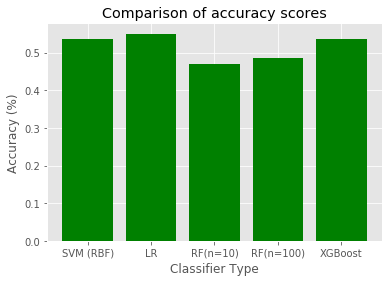

In [0]:
plt.style.use('ggplot')
 
x = ['SVM (RBF)', 'LR', 'RF(n=10)', 'RF(n=100)', 'XGBoost']
accuracy = outputmeans#[53.69, 55.01, 46.86, 48.66, 53.66]
 
x_pos = [i for i, _ in enumerate(x)]
 
plt.bar(x_pos, accuracy, color='green')
plt.xlabel("Classifier Type")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of accuracy scores")
 
plt.xticks(x_pos, x)
 
plt.show()

From online research, XGBoost proved to be a very robust accurate model so we attempt to use it as a classifier here. It shows better results than previous classifiers and allows for hyperparameter optimisation.

XGBoost discerns draws unlike previous classifiers, which is a step in the correct direction for future work.
The displayed prediction results correspond a to an idea of home advantage, where its the easiest to predict a home win (H), and an away win (A) can be predicted better than draw (D). This is inherently due to many models viewing a draw as an even split between a home and away win making classifying difficult.

Comparing Decision Boundaries - XGBoost vs Logistic Regression

In the cell below, we attempt to create a plot decision boundary to see why the model predicts draws, but so poorly. From what we can see, it is inherently difficult for a logistic regression model to predict a draw. From our feature engineering research and online reading, a draw is usually considered as a half-win, half-draw situation which may indicate the binary classification in place. To plot it for XGBoost, there is a markdown line of changing the classifier.

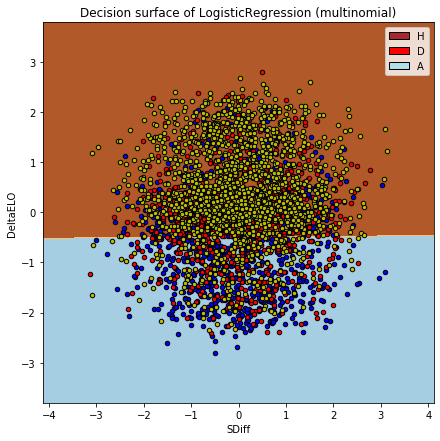

In [0]:
#PLOT DECISION BOUNDARY
from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB #as GNB
import time
from matplotlib.patches import Patch

#centers = [[-5, 0], [0, 1.5], [5, -1]]
#EX, why = make_blobs(n_samples=100, centers=centers, random_state=30)
#transformation = [[0.4, 0.2], [-0.4, 1.2]]
why = y
EX = X#X.loc[:,['SDiff','DeltaStreak']]#np.dot(EX, transformation)
scaler = preprocessing.StandardScaler().fit(EX.loc[:,['SDiff']])
EX.loc[:,['SDiff']] = scaler.transform(EX.loc[:,['SDiff']])
scaler = preprocessing.StandardScaler().fit(EX.loc[:,['DeltaELO']])
EX.loc[:,['DeltaELO']] = scaler.transform(EX.loc[:,['DeltaELO']])

multiclass = 'multinomial'
clf_LRBoundaries = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multiclass)#.fit(EX, why)
#clf_LRBoundaries = GaussianNB()
clf_fitted = clf_LRBoundaries.fit(EX,why)
#clf_fitted = clf_xgb_fitted

EX = EX.to_numpy()
why = why.to_numpy()

h = .02  # step size in the mesh
x_min, x_max = EX[:, 0].min() - 1, EX[:, 0].max() + 1
y_min, y_max = EX[:, 1].min() - 1, EX[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#print(xx.shape)
#print(yy.shape)
Z = clf_fitted.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(7, 7))
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
#proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in plt.cm.Paired]#cs.collections]

legend_elements = [Patch(facecolor='brown', edgecolor='k', label='H'),Patch(facecolor='r', edgecolor='k', label='D'),Patch(facecolor='powderblue', edgecolor='k', label='A')]
plt.legend(handles=legend_elements)

plt.title("Decision surface of LogisticRegression (%s)" % multiclass)
plt.axis('tight')
plt.xlabel('SDiff')
plt.ylabel('DeltaELO')

# Plot also the training points
colors = "bry"
for i, color in zip(clf_fitted.classes_, colors):
  #i = i-1
  idx = np.where(why == i)
  plt.scatter(EX[idx, 0], EX[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor='black', s=20)
  #plt.show()
  #time.sleep(2)



We attempted to import a plot_tree for XGBoost to visualise the model's decision making but it was not as informative as we would've liked. It isn't viable to explain a specific function of a given branch within the tree. But the tree does explain how the model comes to predict a draw.

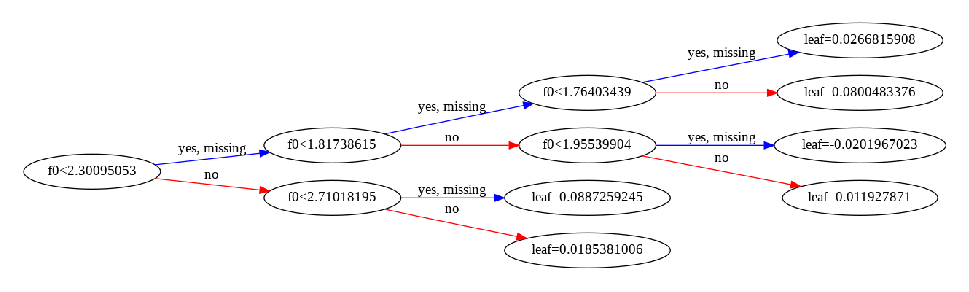

In [0]:
from xgboost import plot_tree

fig = plt.figure(dpi=200,figsize = (6,15))
ax = plt.subplot(1,1,1)
plot_tree(clf_fitted_XGB, num_trees=5, ax = ax, rankdir = 'LR')
#plot_tree(clf_fitted, num_trees=0, rankdir='LR'4
plt.show()

# Section 7: Final Predictions on Test Set

To predict our final test set, we have decided to import data from 2008 to the first half of the 2019 season and create our features to predict with our optimised XGBoost model.

In [0]:
X_finaltest = pd.read_csv('https://raw.githubusercontent.com/hmahendran/epl-data/master/DataFiles/epl-test.csv')

X_finaltest.columns = ["Date", "HomeTeam", "AwayTeam"]
#y = X.FTR
X_finaltest.Date = pd.to_datetime(X_finaltest.Date,dayfirst=True)
#X_finaltest = X_finaltest.loc[0:6,:]

col = ["HAS","HDS","AAS","ADS","f0","f1"]
new_attributes = pd.DataFrame(np.ones((X_finaltest.shape[0],len(col))),columns=col)
X_finaltest = pd.concat([X_finaltest,new_attributes],axis = 1)

X_finaltest

,Date,HomeTeam,AwayTeam,HAS,HDS,AAS,ADS,f0,f1
0,2020-01-11,Bournemouth,Watford,1.0,1.0,1.0,1.0,1.0,1.0
1,2020-01-11,Aston Villa,Man City,1.0,1.0,1.0,1.0,1.0,1.0
2,2020-01-11,Chelsea,Burnley,1.0,1.0,1.0,1.0,1.0,1.0
3,2020-01-11,Crystal Palace,Arsenal,1.0,1.0,1.0,1.0,1.0,1.0
4,2020-01-11,Everton,Brighton,1.0,1.0,1.0,1.0,1.0,1.0
5,2020-01-11,Leicester,Southampton,1.0,1.0,1.0,1.0,1.0,1.0
6,2020-01-11,Man United,Norwich,1.0,1.0,1.0,1.0,1.0,1.0
7,2020-01-11,Sheffield United,West Ham,1.0,1.0,1.0,1.0,1.0,1.0
8,2020-01-11,Tottenham,Liverpool,1.0,1.0,1.0,1.0,1.0,1.0
9,2020-01-11,Wolves,Newcastle,1.0,1.0,1.0,1.0,1.0,1.0


We determine the final SDiff and DeltaELO values for the upcoming games from using all the data up to the first half of the 2019 season.

In [0]:

#Assign strengths
for i in range(0,X_finaltest.shape[0]):
  X_finaltest.HAS[i]=strengthscoreboard.loc['attack_'+X_finaltest.HomeTeam[i],'2019']
  X_finaltest.HDS[i]=strengthscoreboard.loc['defense_'+X_finaltest.HomeTeam[i],'2019']
  X_finaltest.AAS[i]=strengthscoreboard.loc['attack_'+X_finaltest.AwayTeam[i],'2019']
  X_finaltest.ADS[i]=strengthscoreboard.loc['defense_'+X_finaltest.AwayTeam[i],'2019']
  X_finaltest.f0[i] = ((X_finaltest.HAS[i]+X_finaltest.HDS[i])/2)-((X_finaltest.AAS[i]+X_finaltest.ADS[i])/2)
  #X.HAS,X.HDS,X.AAS,X.ADS = 0,0,0,0
#Assign strengths for blind test from penultimate season

X_finaltest = X_finaltest.drop(['HAS','HDS','AAS','ADS'],1)

for i in range(0,X_finaltest.shape[0]):
    X_finaltest.f1[i] = (scoreboard.loc[np.where(Teams == X_finaltest.HomeTeam[i])[0][0],str(2019)]) -(scoreboard.loc[np.where(Teams == X_finaltest.AwayTeam[i])[0][0],str(2019)])

clear_output()
X_finaltest

,Date,HomeTeam,AwayTeam,f0,f1
0,2020-01-11,Bournemouth,Watford,-0.415277,-1.741026
1,2020-01-11,Aston Villa,Man City,-0.261666,-91.830450
2,2020-01-11,Chelsea,Burnley,0.989345,60.031100
3,2020-01-11,Crystal Palace,Arsenal,-0.441088,-39.173284
4,2020-01-11,Everton,Brighton,2.098786,25.485559
5,2020-01-11,Leicester,Southampton,0.080516,16.508321
6,2020-01-11,Man United,Norwich,-0.655648,68.762621
7,2020-01-11,Sheffield United,West Ham,-0.811847,-18.652146
8,2020-01-11,Tottenham,Liverpool,0.501202,-18.378923
9,2020-01-11,Wolves,Newcastle,1.086135,5.437013


Finalising the two main features for our final prediction test.

In [0]:
X_finaltest_temp = X_finaltest.loc[:,['Date','HomeTeam','AwayTeam']]
X_finaltest = X_finaltest.drop(['Date','HomeTeam','AwayTeam'],1)


X_finaltest

,f0,f1
0,-0.415277,-1.741026
1,-0.261666,-91.830450
2,0.989345,60.031100
3,-0.441088,-39.173284
4,2.098786,25.485559
5,0.080516,16.508321
6,-0.655648,68.762621
7,-0.811847,-18.652146
8,0.501202,-18.378923
9,1.086135,5.437013


Our final prediction result as follows:

In [0]:
#TRAIN MODEL WITH OPTIMISED CLASSIFIER

#clf.fit(X_train,y_train) # already using the optimised classifier
y_pred_final = clf_fitted_XGB.predict(X_finaltest) #Using the optimised XGB classifier
#y_pred_final = clf[1].predict(X_finaltest)

clear_output()
y_pred_final

temp = pd.DataFrame(['H' for x in range(0,len(y_pred_final))], columns = ['FTR_pred'])
finalprediction = pd.concat([X_finaltest_temp,temp],axis = 1)

for i in range(0,len(y_pred_final)):
  if y_pred_final[i] == -1:
    finalprediction.FTR_pred[i] = 'A'
  elif y_pred_final[i] == 0:
    finalprediction.FTR_pred[i] = 'D'

clear_output()
finalprediction


,Date,HomeTeam,AwayTeam,FTR_pred
0,2020-01-11,Bournemouth,Watford,A
1,2020-01-11,Aston Villa,Man City,A
2,2020-01-11,Chelsea,Burnley,H
3,2020-01-11,Crystal Palace,Arsenal,A
4,2020-01-11,Everton,Brighton,H
5,2020-01-11,Leicester,Southampton,H
6,2020-01-11,Man United,Norwich,H
7,2020-01-11,Sheffield United,West Ham,A
8,2020-01-11,Tottenham,Liverpool,A
9,2020-01-11,Wolves,Newcastle,H


In [0]:
from google.colab import files
finalprediction.to_csv('finalprediction1.csv',index=False) # Downloading final csv

files.download("finalprediction1.csv")